# Natural Language Processing with Disaster Tweets
### Mini Project for DTSA 5511: Introduction to Deep Learning
#### University of Colorado, Boulder - Master of Science in Data Science

**By:** Andrea Francu  
**Version:** 1.0  
**Date:** Februay 7, 2025

The aim of this project is to develop and train a model that can analyze tweets and determine whether they are truly related to a disaster. This project is part of Kaggle's "Getting Started" competition (https://www.kaggle.com/c/nlp-getting-started/overview) and serves as a mini project for CU Boulder’s DTSA 5511 course. The primary objective is to introduce NLP concepts rather than optimizing for the highest-performing model through multiple iterations. This project requires NLP (Natural Language Processing) which consists of various methods for processing language like text data to make it easier for our models to make predictions.

---

## Data Overview
The train and test data for this project each contain the following features:
- id - a unique identifier for the tweet
- keyword - a keyword from the tweet
- location - the location the tweet was sent from
- text - the text of the tweet
- target - whether a tweet is about a real disaster or not (only in train data)
Some of the data points may not have entries for some features, like keyword or location.

In [28]:
# load in necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# load in the data from train and test csv's into df's, as well as samples submission
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# get a look at the format
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
# some information about the test data set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


---
## Exploratory Data Analysis (EDA)
Now that the data is loaded in, we can do some standard data cleaning and then get a look at some visualizations. A few standard data cleaning methods for text data include converting everything to lowercase, removing special characters and punctuation, and removing extra spaces. Specific to tweets, we can remove any mentions of other accounts, or url's, as these are likely not relevant for the purpose of classifying the tweets. Finally, we can remove common stopwords, like "the", "is", "and" that don't bring any value to our model and perform stemming. Stemming is a common NLP tool that reduces words to their "stem" or root form. An example fo this is reducing "started", "starting", and "starts" to "start." This helps reduce variability, as all those words represent the same meaning.
### Data Cleaning and Preparation

In [4]:
# download stopwords from nltk library
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stemmer = PorterStemmer()

# clean text column of train data
train['text'] = train['text'].str.lower()  # make all text lowercase
train['text'] = train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)  # remove any URLs
train['text'] = train['text'].str.replace(r'@\w+', '', regex=True)  # remove mentions of other accounts
train['text'] = train['text'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)  # remove special characters, keep hashtags as may be relevant
train['text'] = train['text'].str.strip().replace(r'\s+', ' ', regex=True)  # remove extra spaces
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))  # remove stopwords
train['text'] = train['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))  # perform stemming

# clean text column of test data
test['text'] = test['text'].str.lower()  # make all text lowercase
test['text'] = test['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)  # remove any URLs
test['text'] = test['text'].str.replace(r'@\w+', '', regex=True)  # remove mentions of other accounts
test['text'] = test['text'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)  # remove special characters, keep hashtags as may be relevant
test['text'] = test['text'].str.strip().replace(r'\s+', ' ', regex=True)  # remove extra spaces
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))  # remove stopwords
test['text'] = test['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))  # perform stemming

# clean 'keyword' column of train data
train['keyword'] = train['keyword'].str.lower().fillna('')  # convert to lowercase and fill NaNs

# clean 'keyword' column of test data
test['keyword'] = test['keyword'].str.lower().fillna('')  # convert to lowercase and fill NaNs

# clean 'location' column of train data
train['location'] = train['location'].str.lower().fillna('')  # convert to lowercase and fill NaNs
train['location'] = train['location'].str.replace(r'[^a-zA-Z ]', '', regex=True)  # remove special characters
train['location'] = train['location'].str.strip().replace(r'\s+', ' ', regex=True)  # remove extra spaces

# clean 'location' column of test data
test['location'] = test['location'].str.lower().fillna('')  # convert to lowercase and fill NaNs
test['location'] = test['location'].str.replace(r'[^a-zA-Z ]', '', regex=True)  # remove special characters
test['location'] = test['location'].str.strip().replace(r'\s+', ' ', regex=True)  # remove extra spaces

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Also, since we are looking at tweets, hashtags may be very helpful. These are often a few words put together, so we can split up the hashtag by words so that it is more useful to us.

In [5]:
# process hasghtags by splitting up words
def process_hashtags(text):
    hashtags = re.findall(r'#(\w+)', text) # look for all hashtags
    for hashtag in hashtags: # sort through each hashtag
        split_hashtag = ' '.join(re.findall('[A-Z][^A-Z]*', hashtag.title())) # split by words
        text = text.replace(f'#{hashtag}', split_hashtag.lower())
    return text

# replace hashtags in test and train data
train['text'] = train['text'].apply(process_hashtags)
test['text'] = test['text'].apply(process_hashtags)

Now that the data is loaded in and cleaned up, we can take a look at some visualizations. We may have to return back to the data cleaning steps as we get a look at some of the text and find other types of cleaning that needs to be done. We can first look at a histogram of the class distribution to see if there is any class imbalance that needs to be accounted for.
### Data Visualization

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


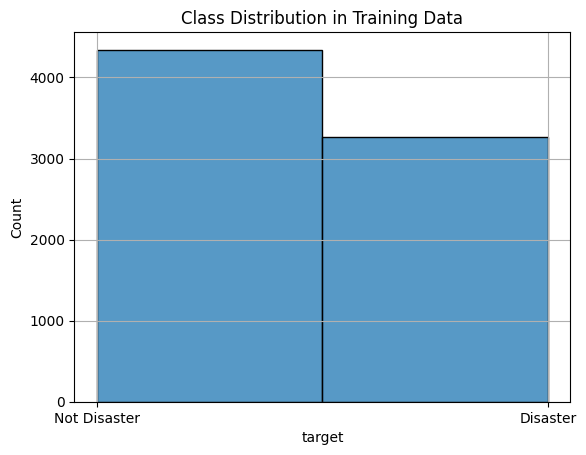

In [6]:
sns.histplot(train['target'], bins = 2)
plt.title("Class Distribution in Training Data")
plt.xticks(ticks = [0,1], labels = ['Not Disaster', 'Disaster'])
plt.grid()
plt.show()

In [7]:
target_counts = train.groupby('target').size()
target_counts

target
0    4342
1    3271
dtype: int64

Based on this class distribution histogram, it appears that there is some slight class imbalance in the training dataset. There are about 4300 tweets labeled as non-disaster, and about 3300 tweets labeled as disaster. This is something that needs to be accounted for when building the model, to ensure that the model isn't inclined to label more things as non-disaster just because of its training data. 

In [8]:
# look at spread of location feature
location_counts = train.groupby('location').size()
location_counts

location
                               2638
a botanical garden probably       1
a box                             1
a feminist modernist hag          1
a hoop somewhere                  1
                               ... 
zboyerwashingtontimescom          1
zeerust south africa              1
zero branco                       1
ziam af                           1
zimbabwe                          1
Length: 2962, dtype: int64

In [9]:
# look at spread of keyword feature
keyword_counts = train.groupby('keyword').size()
keyword_counts

keyword
                       61
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Length: 222, dtype: int64

It looks like location may not be a very helpful feature. No tweet comes from the same location, and many of the entries for this feature are illegible. Therefore, we can just drop this feature. Keyword, however, looks to be mostly formatted properly, and has many tweets with the same keyword, all related to disaster. This feature can be useful to use by giving an idea of the spread of keywords used. A nice way to visualize this is with a word cloud.

In [10]:
# remove location feature from both datasets
train = train.drop('location', axis = 1)
test = test.drop('location', axis = 1)

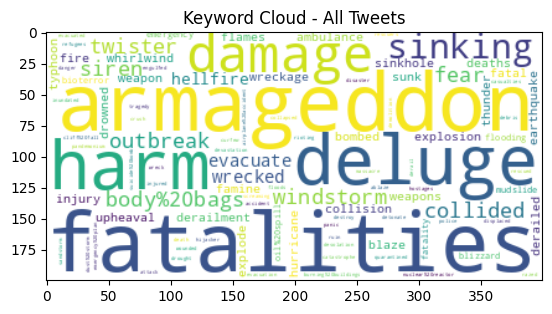

In [11]:
# create wordcloud of keywords
keywords = train['keyword'].dropna().value_counts()
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(keywords)

plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Keyword Cloud - All Tweets")
plt.show()

This word cloud gives a good representation of some of the most common words included in these tweets. It also shows that a few of the phrases have %20 in between the words, which is a way to encode spaces in urls. As part of the data cleaning we can convert all these back into spaces. Another visualization that would be helpful is a word cloud of the keywords for disaster vs. non disaster data. This can give a first look at whether there are some words that are commonly used and misinterpreted as disaster-related, possibly because of vocabulary at the time they were written.

In [12]:
# replace %20 with space
train['keyword'] = train['keyword'].str.replace('%20', ' ')

In [13]:
# create wordcloud of keywords from disaster dataset
keywords_disaster = train[train['target']==1]['keyword'].dropna().value_counts()
wordcloud_disaster = WordCloud(background_color = 'white').generate_from_frequencies(keywords_disaster)

plt.figure()
plt.imshow(wordcloud_disaster, interpolation = 'bilinear')
plt.title("Keyword Cloud - Disaster Tweets")
plt.gca().set_axis_off()
plt.show()

In [14]:
# create wordcloud of keywords from non-disaster dataset
keywords_nondisaster = train[train['target']==0]['keyword'].dropna().value_counts()
wordcloud_nondisaster = WordCloud(background_color = 'white').generate_from_frequencies(keywords_nondisaster)

plt.figure()
plt.imshow(wordcloud_nondisaster, interpolation = 'bilinear')
plt.title("Keyword Cloud - Non-Disaster Tweets")
plt.gca().set_axis_off()
plt.show()

While there are different common keywords for disaster vs. non-disaster tweets, it's pretty hard to differentiate between them without more context from the tweets. Without knowing which subset of data these wordclouds came from, it is pretty hard to tell which one's which without that extra context. It's likely that the most useful data for predicting the classification will be the text data. However, we can still use the keyword data by simply combining it with our text data.

In [15]:
# create new feature that combines text with keywords
train['text_with_keywords'] = train['text'] + ' ' + train['keyword']
test['text_with_keywords'] = test['text'] + ' ' + train['keyword']

Now that the data is cleaned up and likely won't be modified anymore, we can split the training data into train and validation data, so that we can validate our model.

In [16]:
# split the train data into train and validation data to evaluate models performance
X_train, X_val, y_train, y_val = train_test_split(train['text_with_keywords'],
                                                  train['target'], test_size = 0.2, random_state = 123)

---
## Model Architecture
Now that the data's been cleaned and split, we need to convert our text data into something that the model can easily understand. One common method for this is to perform TF-IDF (Term Frequency - Inverse Document Frequency) Vectorization. This creates vectors of the text data by looking at word frequency in the tweet, with respect to word frequency in the whole body of text (all the tweets in the dataset). 

In [17]:
# perform tf-idf vectorization on train and validation text data
tfidf = TfidfVectorizer(
    max_features=10000,  # limit the number of features to 10,000
    ngram_range=(1, 3),  # include unigrams, bigrams, and trigrams
    min_df=2,  # ignore terms that appear in less than 2 documents
    max_df=0.9,  # ignore terms that appear in more than 90% of the documents
    strip_accents='unicode',  # remove accents from characters
    use_idf=True,  # use inverse document frequency weighting
    smooth_idf=True  # smooth idf to avoid division by zero
)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()  # fit on train data and convert to array
X_val_tfidf = tfidf.transform(X_val).toarray()  # transform on validation data - avoid data leakage from train
X_test_tfidf = tfidf.transform(test['text_with_keywords']).toarray()  # use transform, not fit_transform, to avoid data leakage

# use truncated svd (singular value decomposition) to reduce dimensionality
svd = TruncatedSVD(n_components=100)  # reduce to 100 components
X_train_svd = svd.fit_transform(X_train_tfidf)  # fit and transform the train tf-idf data
X_val_svd = svd.transform(X_val_tfidf)  # transform the validation tf-idf data
X_test_svd = svd.transform(X_test_tfidf)  # use transform, not fit_transform

### Hyperparameter Tuning
Now we can start setting up and building a few different models. The following sections were iterated over multiple times. I started with a simple model and added layers, tuned hyperparameters, and implemented new techniques to improve the model iteratively.

In [18]:
num_features = X_train_tfidf.shape[1] # num of features
#f1_score = tf.keras.metrics.F1Score()  # use F1 score (Kaggle uses this as its metric)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True) # early stopping to reduce training time

### LSTM - Long Short Term Memory
The first model I used implemented LSTM, Long Short Term Memory, a type of Recurrent Neural Network (RNN) designed to capture long-range dependencies in sequential data. It helps mitigate the vanishing gradient problem, making it suitable for tasks like text classification.

In [19]:
# initialize sequential model
lstm = Sequential()
# add input layer with shape matching the number of features in X_train_svd (with an additional channel dimension)
lstm.add(Input(shape = (X_train_svd.shape[1], 1)))
# add first LSTM layer with 64 units, ReLU activation, and return_sequences=True for the next LSTM layer
lstm.add(LSTM(64, activation = 'relu', return_sequences = True))
# add dropout layer with 30% drop probability to prevent overfitting
lstm.add(Dropout(0.3))
# add second LSTM layer with 32 units and ReLU activation
lstm.add(LSTM(32, activation = 'relu'))
# add dropout layer with 20% drop probability to prevent overfitting
lstm.add(Dropout(0.2))
# add a dense layer with a single output unit, sigmoid activation for binary classification
lstm.add(Dense(1, activation = 'sigmoid'))

In [20]:
# compile LSTM model
lstm.compile(optimizer = Adam(learning_rate=0.001), 
             loss = 'binary_crossentropy', 
             metrics = ['accuracy'])

In [21]:
# fit the LSTM model on the vectorized train data
lstm.fit(X_train_svd, y_train, 
         epochs = 10, batch_size = 64, 
         validation_data = (X_val_svd, y_val),
         callbacks = [early_stopping])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5643 - loss: 0.6876 - val_accuracy: 0.5772 - val_loss: 0.6815
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5736 - loss: 0.6835 - val_accuracy: 0.5772 - val_loss: 0.6821
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5688 - loss: 0.6839 - val_accuracy: 0.5772 - val_loss: 0.6819
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5732 - loss: 0.6828 - val_accuracy: 0.5772 - val_loss: 0.6828
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5724 - loss: 0.6833 - val_accuracy: 0.5772 - val_loss: 0.6816
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5681 - loss: 0.6844 - val_accuracy: 0.5772 - val_loss: 0.6814
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5719 - loss: 0.6833 - val_accuracy: 0.5772 - val_loss: 0.6815
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5716 - loss: 0.6831 - val_accuracy: 0.5772 - 

### GRU - Gated Recurrent Unit
The second model I used implemented GRU, Gated Recurrent Unit, a type of RNN similar to LSTM but with a simpler architecture. It effectively captures dependencies in sequential data, making it well-suited for tasks like text classification of tweets.

In [22]:
# initialize sequential model for GRU
gru = Sequential()
# add embedding layer to map input features (num_features) to embedding dimension (100)
gru.add(Embedding(input_dim = num_features, output_dim = 100))  
# add GRU layer with 100 units and ReLU activation
gru.add(GRU(100, activation = 'tanh')) 
# add dropout layer with 30% drop probability to prevent overfitting
gru.add(Dropout(0.3))
# add a dense layer with a single output unit and sigmoid activation for binary classification
gru.add(Dense(1, activation = 'sigmoid')) 

In [23]:
# compile GRU model
gru.compile(optimizer = Adam(learning_rate = 0.001), 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

In [24]:
# fit the GRU model on the verctorized train data
gru.fit(X_train_tfidf, y_train, 
        epochs = 10, batch_size = 64, 
        validation_data = (X_val_tfidf, y_val),
        callbacks = [early_stopping])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 424ms/step - accuracy: 0.5570 - loss: 0.6870 - val_accuracy: 0.5772 - val_loss: 0.6813
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.5605 - loss: 0.6870 - val_accuracy: 0.5772 - val_loss: 0.6812
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 420ms/step - accuracy: 0.5644 - loss: 0.6861 - val_accuracy: 0.5772 - val_loss: 0.6820
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.5700 - loss: 0.6854 - val_accuracy: 0.5772 - val_loss: 0.6813
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.5680 - loss: 0.6843 - val_accuracy: 0.5772 - val_loss: 0.6815
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.5672 - loss: 0.6852 - val_accuracy: 0.5772 - val_loss: 0.6817
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.5700 - loss: 0.6839 - val_accuracy: 0.5772 - val_loss: 0.6813


### Logistic Regression
After quite a bit of fine tuning, hyperparameter adjustments, modifications to layers, I still couldn't get a LSTM or GRU model with a F1 score much higher than 0.6, so I tried a simpler model - Logistic Regression. This linear model is effective for binary classification tasks, such as distinguishing between tweet categories, by using a combination of feature weights learned from the data.

In [29]:
# create a parameter grid to iterate through all combinations
param_grid = {
    'penalty': ['l1', 'l2'], # penalties
    'C': [0.1, 1, 10],  # regularization strength
    'solver': ['saga', 'liblinear'],  # solvers to try
    #'max_iter': [100, 200, 300]  # number of iterations for solver to converge
}

# create the logistic regression model
lr = LogisticRegression()

# perform grid search using 5-fold cross-validation and f1 score as metric
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5, scoring = 'f1')

# fit grid search to training data
grid_search.fit(X_train_svd, y_train)

# get the best model from grid search
best_lr = grid_search.best_estimator_

# predict using the validation data
lr_pred = best_lr.predict(X_val_svd)

# Calculate F1 score on validation data
lr_f1 = f1_score(y_val, lr_pred)

# Print the best hyperparameters and the F1 score on validation data
print("Best hyperparameters:", grid_search.best_params_)
print("F1 score on validation data:", lr_f1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
F1 score on validation data: 0.687603305785124


## Results and Analysis
As it turns out, the logistic regression model outperformed the RNN methods - LSTM and GRU. This is possibly because LSTM and GRU are better suited for complex patterns or long-term dependencies in text, but many of these tweets are fairly short and simple, and the vectorization may have captures some of these complexities already. 

In [31]:
# gather performance metrics of the three models 

# use models to make predictions using validation data
lstm_pred = (lstm.predict(X_val_svd) > 0.5).astype(int).squeeze()  # convert to 1D binary predictions
gru_pred = (gru.predict(X_val_svd) > 0.5).astype(int).squeeze()  # convert to 1D binary predictions 

# calculate f1 score 
lstm_f1 = f1_score(y_val, lstm_pred)
gru_f1 = f1_score(y_val, gru_pred)

# calculate accuracy
lstm_acc = accuracy_score(y_val, lstm_pred)
gru_acc = accuracy_score(y_val, gru_pred)
lr_acc = accuracy_score(y_val, lr_pred)

# create a comparison table
comparison_table = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Logistic Regression'],
    'F1 Score': [lstm_f1, gru_f1, lr_f1],
    'Accuracy': [lstm_acc, gru_acc, lr_acc]
})

# Display the metrics table
print(comparison_table)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                 Model  F1 Score  Accuracy
0                 LSTM  0.000000  0.577150
1                  GRU  0.000000  0.577150
2  Logistic Regression  0.687603  0.751806


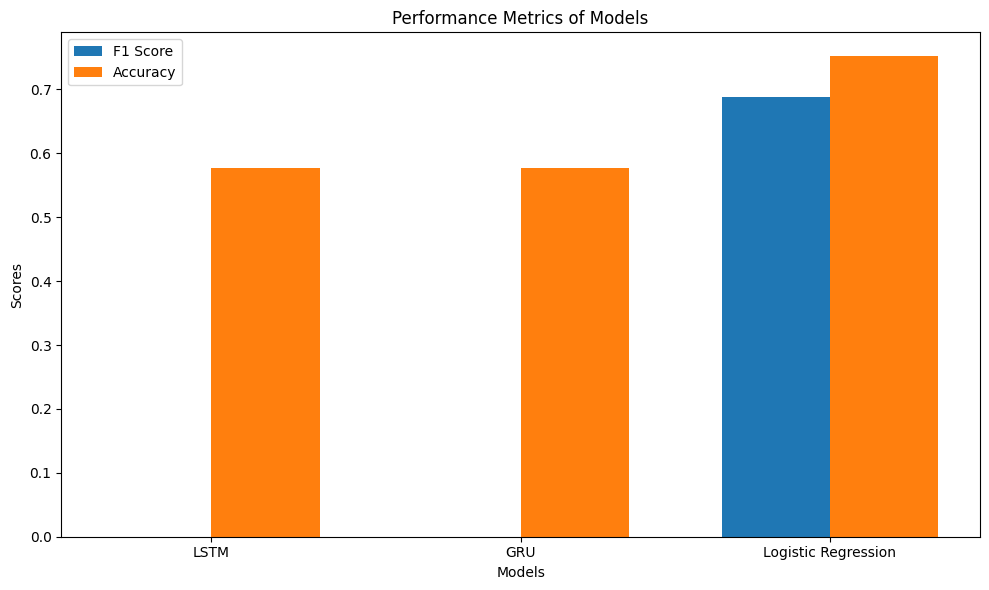

In [32]:
# plot metrics of the three models

# set the width of the bars
bar_width = 0.35
index = np.arange(len(comparison_table))

# create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot F1 Score and Accuracy side by side
bar1 = ax.bar(index, comparison_table['F1 Score'], bar_width, label='F1 Score')
bar2 = ax.bar(index + bar_width, comparison_table['Accuracy'], bar_width, label='Accuracy')

# labeling
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_table['Model'])
ax.legend()

# show the plot
plt.tight_layout()
plt.show()

In [37]:
print(pd.Series(lstm_pred).value_counts())
print(pd.Series(gru_pred).value_counts())

0    1523
Name: count, dtype: int64
0    1523
Name: count, dtype: int64


## Conclusion
As it turns out, the LSTM and GRU models are actually classifying every data point as non-disaster. This may be happening because of how small the dataset is. After many iterations and fine tuning, I unfortunately could not resolve this issue. Therefore, it turns out that logistic regression came out to be the best model, and the simplest. This model gives an F1 score of 0.69 and accuracy of 0.75. If I had more time and resources, I would definitely try to improve my LSTM and GRU models. One possible improvement would be to build it on top of already existing and tuned models. Another improvement could be to use some sentiment analysis models to capture the sentiment in the tweets and use that alongside the other models to figure out if someone is really tweeting about a disaster or not.
### Making Submission
Finally, we can create our submission for the Kaggle competition using the best linear regression model.

In [38]:
lr_pred_test = best_lr.predict(X_test_svd)

# create submission df
submission = pd.DataFrame({
    'id': test['id'],
    'target': lr_pred_test 
})

# save the df to a csv file
submission.to_csv('submission.csv', index=False)